**Importation et traitement des données**

In [47]:
''' On utilise l'API de lichess  pour recuprer les parties de username, n'importe quel joueur lichess'''

import requests
def download_lichess_pgn(username, token, output_file):

    url = f'https://lichess.org/api/games/user/{username}'
    headers = {
        'Authorization': f'Bearer {token}',
        'Accept': 'application/x-chess-pgn'
    }
    params = {
        'max': 3000,
        'clocks': 1,
        'evals': 1,
        'Opening':1,
        'pgnInJson': False,
    }
    response = requests.get(url, headers=headers, params=params, stream=True)

    if response.status_code != 200:
        raise Exception(f"Erreur lors du téléchargement : {response.status_code}")


    with open(output_file, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"Fichier PGN téléchargé et sauvegardé sous {output_file}")


username = 'EricRosen'
token = 'lip_IolWV17XjlvaNCEvqeXd'
output_file = 'games.pgn'
download_lichess_pgn(username, token, output_file)

Fichier PGN téléchargé et sauvegardé sous games.pgn


Pour avoir une vue d'ensemble sur les parties, on récupère le fichier compressé 'lichess_db_standard_rated_2014-09.pgn.zst' depuis https://database.lichess.org/#standard_games. On pourrait en prendre un plus volumineux, mais l'exécution serait plus longue.

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install chess
import chess.pgn
!pip install zstandard
import zstandard as zstd
import statistics as sta
import datetime
import time


compressed_file = "/content/lichess_db_standard_rated_2014-09.pgn.zst"   # Chemin des fichiers
decompressed_file = "/content/lichess_db_standard_rated_2014-09.pgn"


with open(compressed_file, 'rb') as compressed:   # Décompression du zst
    with open(decompressed_file, 'wb') as decompressed:
        dctx = zstd.ZstdDecompressor()
        dctx.copy_stream(compressed, decompressed)

pgn_file_path=decompressed_file

On va à présent récupérer des variables intéressantes comme le classement Elo des joueurs, les coups des parties, l'évaluation de l'ordinateur (attention, certaines valeurs sont manquantes), le temps de réflexion...

On crée également d'autres variables comme 'white_castling_move' ou 'queen_exchange_bool' qui traquent des événements des parties.

In [49]:

class ChessGame:

    def __init__(self, game, username):
        self.white_player = game.headers.get("White", "Unknown")
        self.black_player = game.headers.get("Black", "Unknown")
         # Gestion des valeurs Elo invalides
        try:
            self.white_elo = int(game.headers.get("WhiteElo", 0)) if game.headers.get("WhiteElo") and game.headers.get("WhiteElo").isdigit() else None
        except ValueError:
            self.white_elo = None

        try:
            self.black_elo = int(game.headers.get("BlackElo", 0)) if game.headers.get("BlackElo") and game.headers.get("BlackElo").isdigit() else None
        except ValueError:
            self.black_elo = None
        self.result = game.headers.get("Result", "Unknown")
        self.termination = game.headers.get("Termination", "Unknown")
        self.opening = game.headers.get("Opening", "Unknown")
        self.time_control = game.headers.get("TimeControl", "Unknown")
        self.moves, self.evaluations, self.clocks = self._extract_moves(game)
        self.move_count = len(self.moves)

        self.game_type = self._classify_game_type(self.time_control)  # bullet (le plus rapide), blitz, rapid ou classique (le plus lent)
        self.username = username
        self.centipawn_losses = self._calculate_centipawn_losses()

        Events=important_events(self.moves)
        self.white_queen_taken_bool=main_events(Events,'W','Q')[0]
        self.white_queen_taken_move=main_events(Events,'W','Q')[1]
        self.black_queen_taken_bool=main_events(Events,'B','Q')[0]
        self.black_queen_taken_move=main_events(Events,'B','Q')[1]
        self.white_castling_bool=main_events(Events,'W','C')[0]
        self.white_castling_move=main_events(Events,'W','C')[1]
        self.black_castling_bool=main_events(Events,'B','C')[0]
        self.black_castling_move=main_events(Events,'B','C')[1]
        if self.white_queen_taken_bool and self.black_queen_taken_bool :
            self.queen_exchange_bool= abs(self.black_queen_taken_move-self.white_queen_taken_move)<2
        else : self.queen_exchange_bool= False
        if self.queen_exchange_bool :
            self.queen_exchange_move=max(self.white_queen_taken_move,self.black_queen_taken_move)
        else : self.queen_exchange_move='NaN'

    def _extract_moves(self, game):
        moves = []
        evaluations = []  #tab des evaluations
        clocks = []  #tab du temps restant
        for node in game.mainline():
            move = node.move.uci()
            moves.append(move)
            if "eval" in node.comment:
                    eval_str = node.comment.split("[%eval ")[1].split("]")[0]
                    try:
                        # Si l'évaluation est un chiffre, tronquer à [-12, 12]
                        eval_value = float(eval_str)
                        eval_value = max(-12, min(12, eval_value))  # Tronquer à [-12, 12]
                        evaluations.append(eval_value)
                    except ValueError:

                        if eval_str.startswith("#"):  #on tronque l evaluation a 12 en cas de mat en un certain nombres de coups
                            if eval_str[1:].isdigit():
                                evaluations.append(12)
                            elif eval_str[1:].startswith("-") and eval_str[2:].isdigit():
                                evaluations.append(-12)
                        else:
                            evaluations.append(None)
            else:
                evaluations.append(None)

            # Récupérer le temps restant
            if "clk" in node.comment:
                clk_str = node.comment.split("[%clk ")[1].split("]")[0]
                clocks.append(clk_str)
            else:
                clocks.append(None)

        return moves, evaluations, clocks

    def _calculate_centipawn_losses(self):
        """Calcule la perte en centipions pour chaque coup."""
        centipawn_losses = []
        for i in range(1, len(self.evaluations)):
            if self.evaluations[i] is not None and self.evaluations[i - 1] is not None:
                loss = abs(self.evaluations[i] - self.evaluations[i - 1])
                centipawn_losses.append(loss)
            else:
                centipawn_losses.append(None)  # Si une évaluation manque
        return centipawn_losses

    def _classify_game_type(self, time_control):
        """
        Classe le type de la partie en fonction du TimeControl.
        Exemples de time_control :
        - "300+5" : 5 minutes avec incrément 5 sec (blitz)
        - "60+0" : 1 minute sans incrément (bullet)
        - "1800+0" : 30 minutes sans incrément (rapid)
        """
        if not time_control or time_control == "-":
            return "Unknown"

        try:
            base, increment = time_control.split("+")
            base = int(base)  # Temps de base en secondes
            increment = int(increment)  # Incrément

            total_time = base + (40 * increment)
            if total_time < 180:  # 180 secondes=3 minutes
                return "Bullet"
            elif total_time <= 600:
              return "Blitz"
            elif total_time <= 1800:
              return "Rapid"
            else:
              return "Classical"   #plus de 30 minutes
        except ValueError:
            return "Unknown"

def fetch_games_from_pgn(pgn_file_path, username, max_games=2000000):

    games_list = []


    with open(pgn_file_path) as pgn_file:
        for _ in range(max_games):
            game = chess.pgn.read_game(pgn_file)
            if game is None:
                break


            chess_game = ChessGame(game, username=username)


            games_list.append({           # d'autres variables peuvent s'ajouter
                "White": chess_game.white_player,
                "Black": chess_game.black_player,
                "WhiteElo": chess_game.white_elo,
                "BlackElo": chess_game.black_elo,
                "Result": chess_game.result,
                "Termination": chess_game.termination,
                "Opening": chess_game.opening,
                "TimeControl": chess_game.time_control,
                "MoveCount": chess_game.move_count,
                "Moves": chess_game.moves,
                "evaluations": chess_game.evaluations,
                "clocks":chess_game.clocks,
                "game_type":chess_game.game_type,
                "centipawn_losses": chess_game.centipawn_losses,
                "white_queen_taken_bool":chess_game.white_queen_taken_bool,
                "white_queen_taken_move":chess_game.white_queen_taken_move,
                "black_queen_taken_bool":chess_game.black_queen_taken_bool,
                "black_queen_taken_move":chess_game.black_queen_taken_move,
                "white_castling_bool":chess_game.white_castling_bool,
                "white_castling_move":chess_game.white_castling_move,
                "black_castling_bool":chess_game.black_castling_bool,
                "black_castling_move":chess_game.black_castling_move,
                "queen_exchange_bool":chess_game.queen_exchange_bool,
                "queen_exchange_move":chess_game.queen_exchange_move
            })

    return pd.DataFrame(games_list)



def statistiques_descriptives(df):


  results_count = df["Result"].value_counts()
  print("\nRépartition des résultats :")
  print(results_count)


  plt.figure(figsize=(6, 6))
  plt.pie(results_count, labels=results_count.index, autopct='%1.1f%%', colors=["lightgreen", "lightcoral", "lightblue"])
  plt.title("Répartition des résultats (Blancs, Noirs, Nulles)")
  plt.show()

  average_moves = df["MoveCount"].mean()
  print(f"\nNombre moyen de coups par partie : {average_moves:.2f}")


  plt.figure(figsize=(8, 5))
  plt.hist(df["MoveCount"], bins=10, color="skyblue", edgecolor="black")
  plt.title("Distribution du nombre de coups par partie")
  plt.xlabel("Nombre de coups")
  plt.ylabel("Fréquence")
  plt.show()



  df = df.rename(columns={"opening": "Opening", "result": "Result", "winner": "Winner"})
  df["Result"] = df["Result"].replace({"1-0": "White", "0-1": "Black", "1/2-1/2": "Draw"})


  top_openings = df["Opening"].value_counts().head(20).index   #20 ouvertures les plus frequentes


  opening_win_rate = (      #taux de victoire par ouverture
    df[df["Result"] != "Draw"]
    .groupby("Opening")["Result"]
    .value_counts(normalize=True)
    .unstack()
    .loc[top_openings]
  )


  opening_win_rate["White Win Rate (%)"] = (opening_win_rate["White"] * 100).round(2)


  result_df = opening_win_rate[["White Win Rate (%)"]].reset_index()


  print(result_df)
  game_type_counts = df["game_type"].value_counts()
  print("\nNombre de parties par type :")
  print(game_type_counts)

  # Visualisation sous forme de diagramme
  plt.figure(figsize=(8, 6))
  game_type_counts.plot(kind="bar", color=["lightblue", "lightgreen", "lightcoral", "gold"])
  plt.title("Nombre de parties par type")
  plt.xlabel("Type de partie")
  plt.ylabel("Nombre de parties")
  plt.xticks(rotation=0)
  plt.show()

  centipawn_losses = []
  max_moves = 0

  for _, row in df.iterrows():
        evaluations = row["evaluations"]
        if evaluations and isinstance(evaluations, list):
            losses = []
            for i in range(1, len(evaluations)):
                if evaluations[i] is not None and evaluations[i - 1] is not None:
                    loss = abs(evaluations[i] - evaluations[i - 1])
                    losses.append(loss)
                else:
                    losses.append(None)  # Si une évaluation manque, ignorer ce coup
            centipawn_losses.append(losses)
            max_moves = max(max_moves, len(losses))

    # Calcule la perte moyenne par numéro de coup
  losses_per_move = [[] for _ in range(max_moves)]
  for losses in centipawn_losses:
      for move_idx, loss in enumerate(losses):
          if loss is not None:
              losses_per_move[move_idx].append(loss)


  average_losses = [np.mean(move_losses) if len(move_losses) > 0 else None for move_losses in losses_per_move]

  plt.figure(figsize=(12, 6))
  plt.plot(range(1, len(average_losses) + 1), average_losses, marker="o", color="blue")
  plt.title("Perte moyenne de pions par numéro de coup")
  plt.xlabel("Numéro de coup")
  plt.ylabel("Perte moyenne de pions")
  plt.grid(True)
  plt.tight_layout()
  plt.show()

def plays_white(data): #this function takes the dataframe of the games of one player and gives back a column composed of 0s and 1s : 1 if the game was won
    White=[]
    for i in data['White']:
        if i==username:
            White.append(1)
        else:
            White.append(0)
    return White

def won (data) : #this function takes the dataframe of the games of one player and gives back a column composed of 0s and 1s : 1 if the player played white
    Won=[]
    for i in range(len(data['Result'])):
        if data['Plays_white'][i]==1:
            Won.append(int([*data['Result'][i]][0]))
        else:
            Won.append(int([*data['Result'][i]][2]))
    return Won

def convert_clock(list_clock): #this function converts a chess clock in format '00:00:59" into an integer that is the number of seconds
    new_clock=[]
    for i in list_clock :
        x = time.strptime(i.split(',')[0],'%H:%M:%S')
        new_clock.append(datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds())
    return new_clock


def add_variables_perso (data): #this function takes the dataframe of the games of one player and adds a few columns to the data set, namely the mean evaluations and seconds used at relevant moments of the game
    # Retrieve only the chosen player evaluations and clocks
    their_times=[]
    their_evals=[]
    for i in range(len(data['White'])):
        if data['White'][i]==1 :
            their_times.append(convert_clock(data['clocks'][i][::2]))
            their_evals.append(data['evaluations'][i][::2])
        else :
            their_times.append(convert_clock(data['clocks'][i][1::2]))
            their_evals.append(data['evaluations'][i][1::2])
    #initiate new variables
    m_o_r=[]
    m_m_1_r=[]
    m_m_2_r=[]
    m_e_r=[]
    m_o_t=[]
    m_m_1_t=[]
    m_m_2_t=[]
    m_e_t=[]
    Len_game=[]
    for i in range(len(data['White'])): #compute the variables
        try :
            First_eval=their_evals[i][0]
        except IndexError :
            their_evals[i]=[None]
        if (First_eval is None) :
            means_ev=['NaN' for k in range(4)]
            n= len(their_times[i])
            if n>30 :
                indices=[(0,10), (10,20), (20,30),(30,n)] #split the moves in four categories : opening (5 moves), middle game 1 (10 moves), middle game 2 (10 moves), end game (The remaining moves)
                means_time=[sta.mean(their_times[i][a:b]) for a,b in indices] #compute for each slice the mean time taken for the move
                Len_game.append("Long") #Get the length of the game based on the number of moves
            elif n>20 :
                indices=[(0,10), (10,20),(20,n)]
                means_time=[sta.mean(their_times[i][a:b]) for a,b in indices]
                means_time.append('NaN') #NaN is added if there wasn't enough moves in the game to complete the last slices
                Len_game.append("Medium")
            elif n>10 :
                indices=[(0,10), (10,n)]
                means_time=[sta.mean(their_times[i][a:b]) for a,b in indices]
                means_time+=['NaN','NaN']
                Len_game.append("Short")
            else : #If the game had less than 6 moves the analysis in terms of opening, middle game, is not useful : nothing is computed
                means_time=['NaN' for k in range(4)]
                Len_game.append("Too Short")
        else :
            their_evals_clean_i=[]
            for j in their_evals[i] :
                if j is None :
                    their_evals_clean_i.append(0)
                else :
                    their_evals_clean_i.append(j)
            n= len(their_evals_clean_i)
            if n>30 :
                indices=[(0,10), (10,20), (20,30),(30,n)] #split the moves in four categories : opening (5 moves), middle game 1 (10 moves), middle game 2 (10 moves), end game (The remaining moves)
                means_ev=[sta.mean(their_evals_clean_i[a:b]) for a,b in indices] #compute for each slice the mean rating of the move
                means_time=[sta.mean(their_times[i][a:b]) for a,b in indices] #compute for each slice the mean time taken for the move
                Len_game.append("Long") #Get the length of the game based on the number of moves
            elif n>20 :
                indices=[(0,10), (10,20),(20,n)]
                means_ev=[sta.mean(their_evals_clean_i[a:b]) for a,b in indices]
                means_time=[sta.mean(their_times[i][a:b]) for a,b in indices]
                means_time.append('NaN') #NaN is added if there wasn't enough moves in the game to complete the last slices
                means_ev.append('NaN')
                Len_game.append("Medium")
            elif n>10 :
                indices=[(0,10), (10,n)]
                means_ev=[sta.mean(their_evals_clean_i[a:b]) for a,b in indices]
                means_time=[sta.mean(their_times[i][a:b]) for a,b in indices]
                means_time+=['NaN','NaN']
                means_ev+=['NaN','NaN']
                Len_game.append("Short")
            else : #If the game had less than 6 moves the analysis in terms of opening, middle game, is not useful : nothing is computed
                means_ev=['NaN' for k in range(4)]
                means_time=['NaN' for k in range(4)]
                Len_game.append("Too Short")

        m_o_r.append(means_ev[0]) #Then the computed measures are added
        m_m_1_r.append(means_ev[1])
        m_m_2_r.append(means_ev[2])
        m_e_r.append(means_ev[3])
        m_o_t.append(means_time[0])
        m_m_1_t.append(means_time[1])
        m_m_2_t.append(means_time[2])
        m_e_t.append(means_time[3])

    Enemy_queen_move=[] #initiate new variables
    Enemy_castling_move=[]
    Enemy_castling_dummy=[]
    Player_queen_move=[]
    Player_castling_move=[]
    Player_castling_dummy=[]
    Elo_diff=[]
    for i in range(len(data['White'])): #splits the games info into variables specific to the player considered or their opponent
        if data['White'][i]==1 :
            Elo_diff.append(data['WhiteElo'][i]-data['BlackElo'][i])
            Enemy_queen_move.append(data['black_queen_taken_move'][i])
            Enemy_castling_move.append(data['black_castling_move'][i])
            Player_queen_move.append(data['white_queen_taken_move'][i])
            Player_castling_move.append(data['white_castling_move'][i])
            if data["white_castling_bool"][i]:
                Player_castling_dummy.append(1)
            else :
                Player_castling_dummy.append(0)
            if data["black_castling_bool"][i]:
                Enemy_castling_dummy.append(1)
            else :
                Enemy_castling_dummy.append(0)
        else :
            Elo_diff.append(data['BlackElo'][i]-data['WhiteElo'][i])
            Player_queen_move.append(data['black_queen_taken_move'][i])
            Player_castling_move.append(data['black_castling_move'][i])
            Enemy_queen_move.append(data['white_queen_taken_move'][i])
            Enemy_castling_move.append(data['white_castling_move'][i])
            if data["black_castling_bool"][i]:
                Player_castling_dummy.append(1)
            else :
                Player_castling_dummy.append(0)
            if data["white_castling_bool"][i]:
                Enemy_castling_dummy.append(1)
            else :
                Enemy_castling_dummy.append(0)
    L_g_ts=[] #initiate new variables
    L_g_s=[]
    L_g_m=[]
    L_g_l=[]
    for i in Len_game : #Len game is transformed into four dummies
        if i=='Too Short':
            L_g_ts.append(1)
            L_g_s.append(0)
            L_g_m.append(0)
            L_g_l.append(0)
        elif i=='Short':
            L_g_ts.append(0)
            L_g_s.append(1)
            L_g_m.append(0)
            L_g_l.append(0)
        elif i=='Medium':
            L_g_ts.append(0)
            L_g_s.append(0)
            L_g_m.append(1)
            L_g_l.append(0)
        elif i=='Long':
            L_g_ts.append(0)
            L_g_s.append(0)
            L_g_m.append(0)
            L_g_l.append(1)
    queen_exchange_dummy=[]

    for i in data["queen_exchange_bool"]:
        if i :
            queen_exchange_dummy.append(1)
        else :
            queen_exchange_dummy.append(0)
    data["Player_castling_dummy"]=Player_castling_dummy #the new colums are added to the data set
    data["Enemy_castling_dummy"]=Enemy_castling_dummy
    data["queen_exchange_dummy"]=queen_exchange_dummy
    data["Enemy_queen_taken_move"]=Enemy_queen_move
    data["Enemy_castling_move"]=Enemy_castling_move
    data["Player_queen_taken_move"]=Player_queen_move
    data["Player_castling_move"]=Player_castling_move
    data["Elo_diff"]=Elo_diff
    data["length_game_too_short"]=L_g_ts
    data["length_game_short"]=L_g_s
    data["length_game_medium"]=L_g_m
    data["length_game_long"]=L_g_l
    data["length_game"]=Len_game
    data["mean_opening_rating"]=m_o_r #the new colums are added to the data set
    data["mean_middle1_rating"]=m_m_1_r
    data["mean_middle2_rating"]=m_m_2_r
    data["mean_end_rating"]=m_e_r
    data["mean_opening_time"]=m_o_t
    data["mean_middle1_time"]=m_m_1_t
    data["mean_middle2_time"]=m_m_2_t
    data["mean_end_time"]=m_e_t

def convert(a,b) : #this function takes a position on the board in format 'a4' and converts it to a tuple composed of two integers
    if a == 'a' : return (11,int(b))
    elif a == 'b' : return (12,int(b))
    elif a == 'c' : return (13,int(b))
    elif a == 'd' : return (14,int(b))
    elif a == 'e' : return (15,int(b))
    elif a == 'f' : return (16,int(b))
    elif a == 'g' : return (17,int(b))
    elif a == 'h' : return (18,int(b))

def important_events (moves) : #This function takes a sequence of moves in UCI format, simulates the game and lists all important events in the game (a piece taken or castling)
    Initial_board=[(a,b) for a in [11,12,13,14,15,16,17,18] for b in [1,2,3,4,5,6,7,8]] #creates the initial empty board of positions
    Pieces=[('WRa',5),('WPa',1),0,0,0,0,('BPa',1),('BRa',5), #a piece is described by a tuple : a string with its color 'W', its type 'R' and its column of start if it needs to be differentiated 'a' ; and an integer with its "value"
    ('WNb',3),('WPb',1),0,0,0,0,('BPb',1),('BNb',3),
    ('WBc',3),('WPc',1),0,0,0,0,('BPc',1),('BBc',3),
    ('WQ',9),('WPd',1),0,0,0,0,('BPd',1),('BQ',9),
    ('WK',0),('WPe',1),0,0,0,0,('BPe',1),('BK',0),
    ('WBf',3),('WPf',1),0,0,0,0,('BPf',1),('BBf',3),
    ('WNg',3),('WPg',1),0,0,0,0,('BPg',1),('BNg',3),
    ('WRh',5),('WPh',1),0,0,0,0,('BPh',1),('BRh',5)] # lists all pieces in the game
    Board={}
    k=0
    for j in Initial_board : # Assignate in a dictionnary a piece or a 0 (items) for each position (keys)
        Board[j]=Pieces[k]
        k+=1
    number_move=1
    Events=[]
    for i in moves :
        uci_list=[*i]
        initial=convert(uci_list[0],uci_list[1])
        final=convert(uci_list[2],uci_list[3]) #converts the uci format into our format of starting and end position for a moving piece
        if Board[final]!=0 : #If there is already a piece in the final position, that piece and the move are added to the Events list
            Events.append([Board[final],number_move])
        Board[final]=Board[initial]
        Board[initial]=0
        if i== 'e1g1' and number_move<30 : #If there is castling the rook also needs to be moved, and the castling is added to the Events list
            initial=convert('h','1')
            final=convert('f','1')
            Board[final]=Board[initial]
            Board[initial]=0
            Events.append([('WCS',0),number_move]) #CS stands for 'Castling' 'Small'
        elif i== 'e1c1' and number_move<30:
            initial=convert('a','1')
            final=convert('d','1')
            Board[final]=Board[initial]
            Board[initial]=0
            Events.append([('WCG',0),number_move]) #CG stands for 'Castling' 'Great'
        elif i== 'e8g8' and number_move<30:
            initial=convert('h','8')
            final=convert('f','8')
            Board[final]=Board[initial]
            Board[initial]=0
            Events.append([('BCS',0),number_move])
        elif i== 'e8c8' and number_move<30:
            initial=convert('a','8')
            final=convert('d','8')
            Board[final]=Board[initial]
            Board[initial]=0
            Events.append([('BCG',0),number_move])
        number_move+=1
    return Events

def main_events (events,color,piece) : #This function takes a list of events in a game (computed by important events), the color as a string 'W', the type of piece as a string 'Q', and gives back a tuple
    #first a boolean of wether or not that piece was taken during the game (or the castling made), then either an integer (if that piece was taken) that stands for the move at which it happened; or a string 'NaN' if the piece was not taken
    for i in events:
        if [*i[0][0]][0]==color and [*i[0][0]][1]==piece :
            return (True,i[1])
    return (False,'NaN')

if __name__ == "__main__":
    df_games = fetch_games_from_pgn(pgn_file_path,username, max_games=100000)
    df_games_perso=fetch_games_from_pgn("/content/games.pgn",username,max_games=2000)





On peut à présent afficher quelques statistiques descriptives intéressantes.

In [50]:
def statistiques_descriptives(df):


  results_count = df["Result"].value_counts()
  print("\nRépartition des résultats :")
  print(results_count)


  plt.figure(figsize=(6, 6))
  plt.pie(results_count, labels=results_count.index, autopct='%1.1f%%', colors=["lightgreen", "lightcoral", "lightblue"])
  plt.title("Répartition des résultats (Blancs, Noirs, Nulles)")
  plt.show()

  average_moves = df["MoveCount"].mean()
  print(f"\nNombre moyen de coups par partie : {average_moves:.2f}")


  plt.figure(figsize=(8, 5))
  plt.hist(df["MoveCount"], bins=10, color="skyblue", edgecolor="black")
  plt.title("Distribution du nombre de coups par partie")
  plt.xlabel("Nombre de coups")
  plt.ylabel("Fréquence")
  plt.show()



  df = df.rename(columns={"opening": "Opening", "result": "Result", "winner": "Winner"})
  df["Result"] = df["Result"].replace({"1-0": "White", "0-1": "Black", "1/2-1/2": "Draw"})


  top_openings = df["Opening"].value_counts().head(20).index   #20 ouvertures les plus frequentes


  opening_win_rate = (      #taux de victoire par ouverture
    df[df["Result"] != "Draw"]
    .groupby("Opening")["Result"]
    .value_counts(normalize=True)
    .unstack()
    .loc[top_openings]
  )


  opening_win_rate["White Win Rate (%)"] = (opening_win_rate["White"] * 100).round(2)


  result_df = opening_win_rate[["White Win Rate (%)"]].reset_index()


  print(result_df)
  game_type_counts = df["game_type"].value_counts()
  print("\nNombre de parties par type :")
  print(game_type_counts)

  # Visualisation sous forme de diagramme
  plt.figure(figsize=(8, 6))
  game_type_counts.plot(kind="bar", color=["lightblue", "lightgreen", "lightcoral", "gold"])
  plt.title("Nombre de parties par type")
  plt.xlabel("Type de partie")
  plt.ylabel("Nombre de parties")
  plt.xticks(rotation=0)
  plt.show()

  centipawn_losses = []
  max_moves = 0

  for _, row in df.iterrows():
        evaluations = row["evaluations"]
        if evaluations and isinstance(evaluations, list):
            losses = []
            for i in range(1, len(evaluations)):
                if evaluations[i] is not None and evaluations[i - 1] is not None:
                    loss = abs(evaluations[i] - evaluations[i - 1])
                    losses.append(loss)
                else:
                    losses.append(None)  # Si une évaluation manque, ignorer ce coup
            centipawn_losses.append(losses)
            max_moves = max(max_moves, len(losses))

    # Calcule la perte moyenne par numéro de coup
  losses_per_move = [[] for _ in range(max_moves)]
  for losses in centipawn_losses:
      for move_idx, loss in enumerate(losses):
          if loss is not None:
              losses_per_move[move_idx].append(loss)


  average_losses = [np.mean(move_losses) if len(move_losses) > 0 else None for move_losses in losses_per_move]

  plt.figure(figsize=(12, 6))
  plt.plot(range(1, len(average_losses) + 1), average_losses, marker="o", color="blue")
  plt.title("Perte moyenne de pions par numéro de coup")
  plt.xlabel("Numéro de coup")
  plt.ylabel("Perte moyenne de pions")
  plt.grid(True)
  plt.tight_layout()
  plt.show()



Répartition des résultats :
Result
1-0        50168
0-1        46029
1/2-1/2     3803
Name: count, dtype: int64


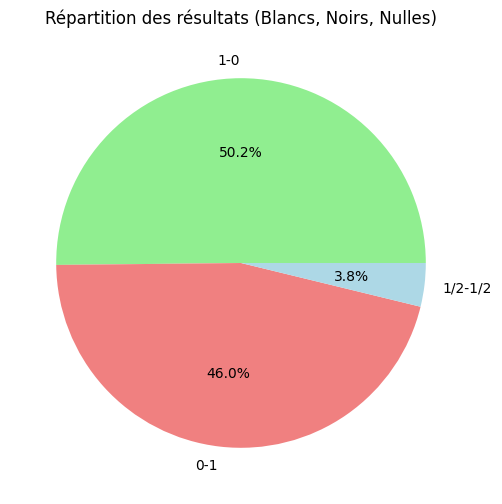


Nombre moyen de coups par partie : 67.86


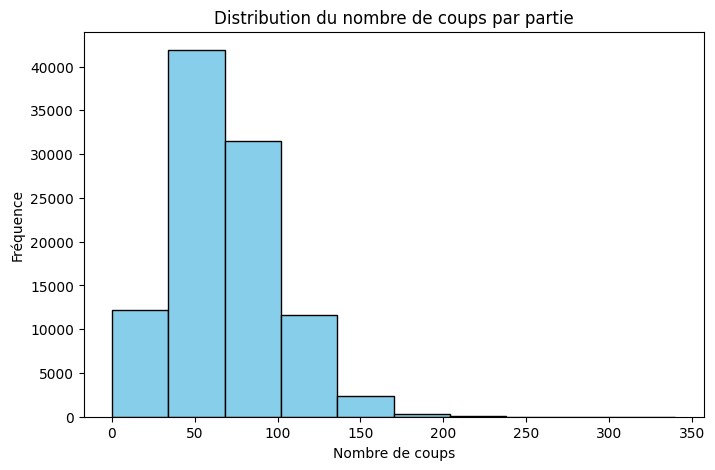

Result                                        Opening  White Win Rate (%)
0                                Van't Kruijs Opening               47.55
1                                      Modern Defense               53.68
2       Scandinavian Defense: Mieses-Kotroc Variation               58.61
3                                     Horwitz Defense               57.75
4                                        Owen Defense               51.80
5                    French Defense: Knight Variation               51.11
6                                   Hungarian Opening               51.09
7                                    Sicilian Defense               41.81
8                                   Caro-Kann Defense               47.89
9                                Queen's Pawn Game #2               54.24
10                   Sicilian Defense: Bowdler Attack               44.10
11                               Scandinavian Defense               46.52
12                                Phil

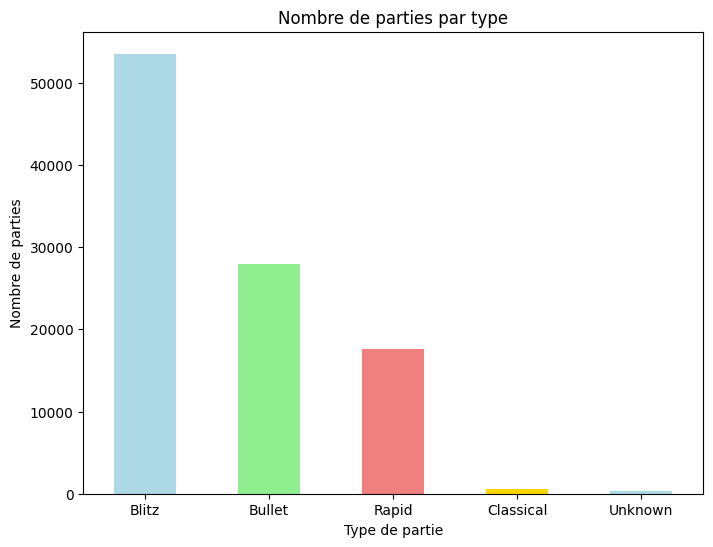

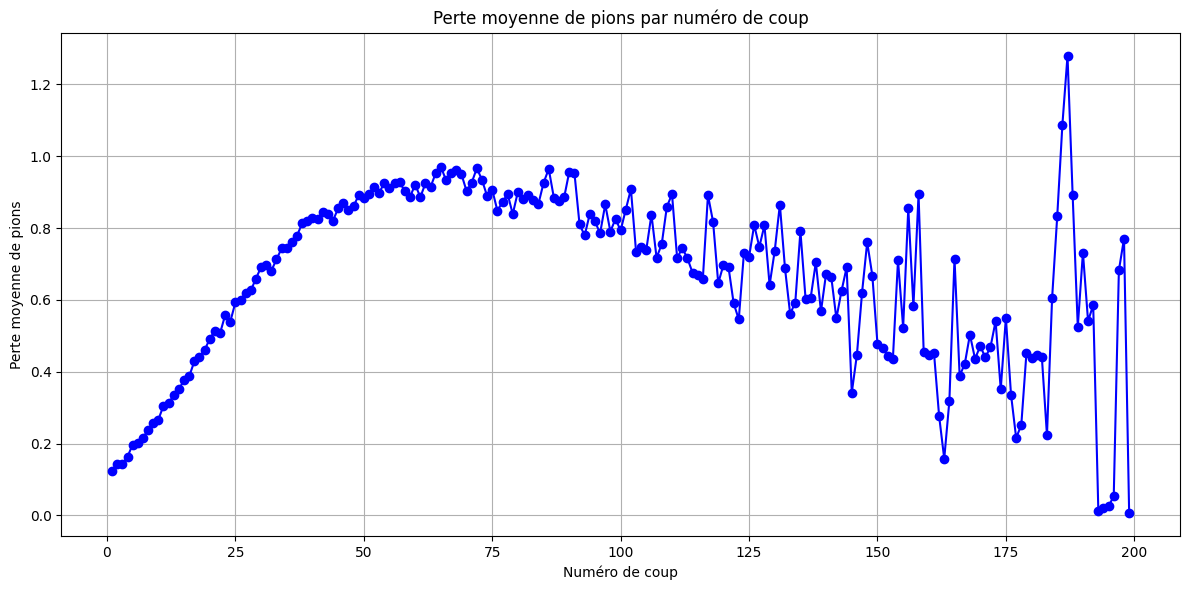

In [51]:
statistiques_descriptives(df_games)

Une partie dure en moyenne 68 coups. On a un léger avantage aux blancs en termes de winrate. Le blitz est de loin le mode de jeu le plus populaire. Le dernier graphique donne l'évolution de la perte en pion à chaque coup (cela détermine la qualité des coups). Plus la position du joueur est détériorée après le coup, plus la perte est grande. Jouer le meilleur coup (selon l'évaluation de l'ordinateur) donne donc une perte nulle. On remarque que les joueurs font plus d'erreurs à mesure que la partie progresse, jusqu'au 50e coup. On observe ensuite une légère baisse jusqu'au 100e coup. Après 125 coups, il est difficile de tirer des conclusions, car seul un petit nombre de parties arrivent jusque-là.


Répartition des résultats :
Result
1-0        14102
0-1        12969
1/2-1/2      886
Name: count, dtype: int64


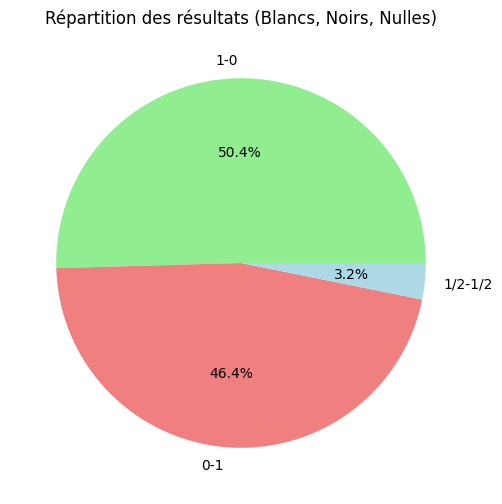


Nombre moyen de coups par partie : 66.65


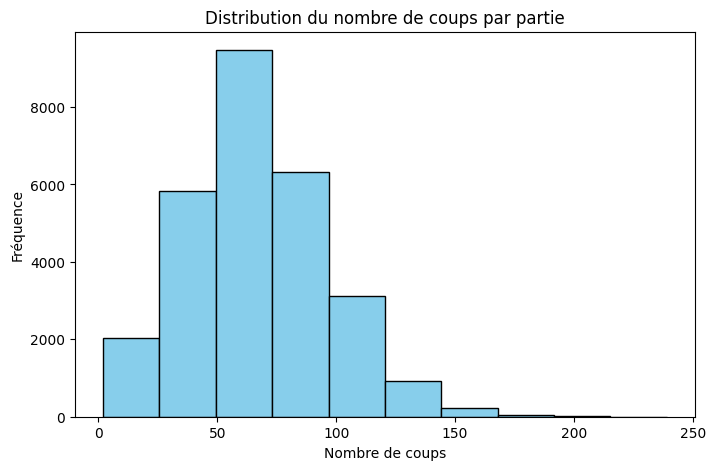

Result                                        Opening  White Win Rate (%)
0                                Van't Kruijs Opening               46.60
1                                      Modern Defense               52.60
2                                   Hungarian Opening               51.67
3                                        Owen Defense               54.76
4                                      Mieses Opening               53.48
5                                     Horwitz Defense               60.16
6       Scandinavian Defense: Mieses-Kotroc Variation               52.97
7                                 Nimzo-Larsen Attack               46.92
8                                   Caro-Kann Defense               43.25
9                    French Defense: Knight Variation               48.74
10                               Queen's Pawn Game #2               56.84
11                               Scandinavian Defense               50.36
12                                    

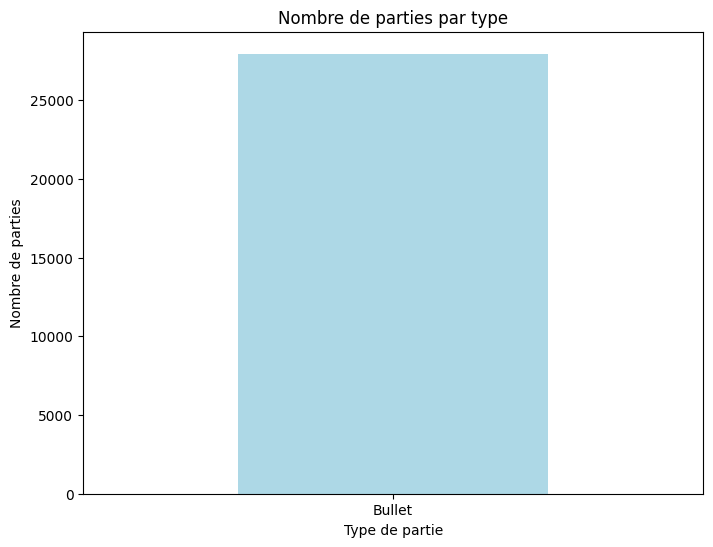

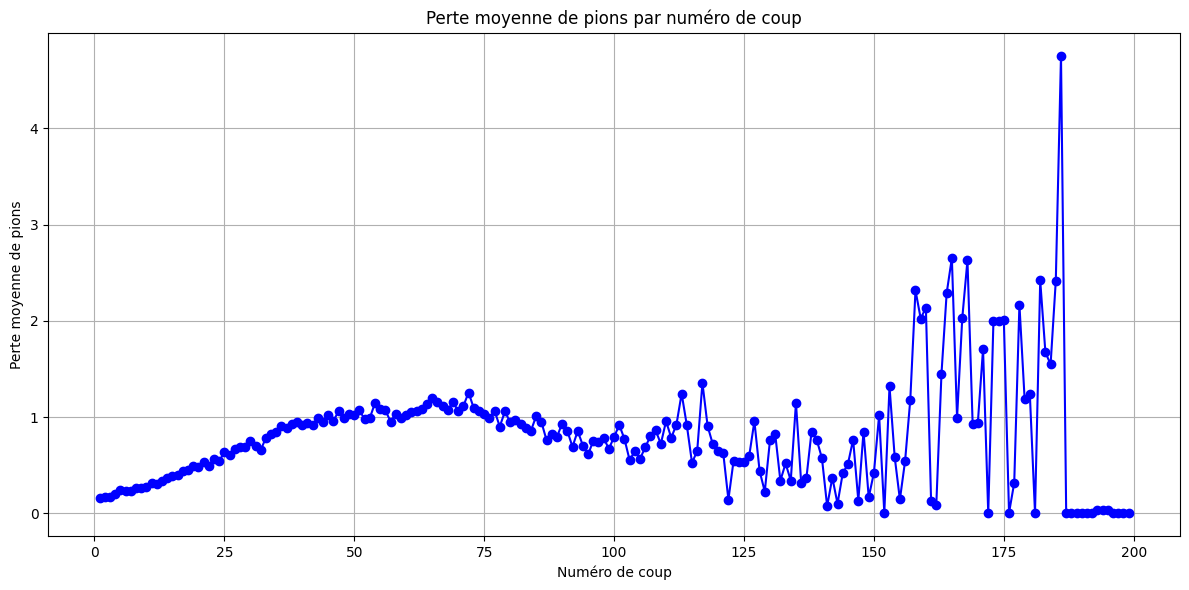

In [52]:
filtered_df_bullet = df_games[df_games["game_type"] == "Bullet"]
statistiques_descriptives(filtered_df_bullet)



Répartition des résultats :
Result
1-0        26862
0-1        24525
1/2-1/2     2161
Name: count, dtype: int64


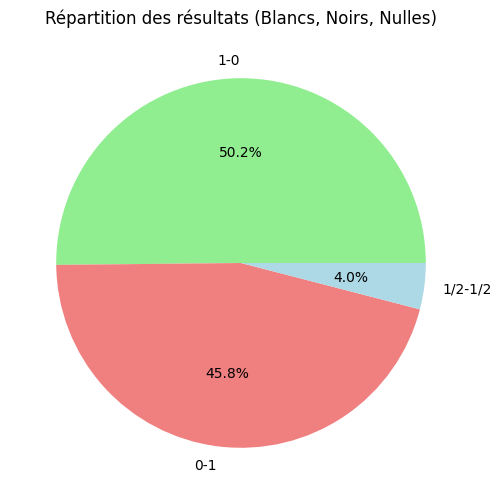


Nombre moyen de coups par partie : 69.49


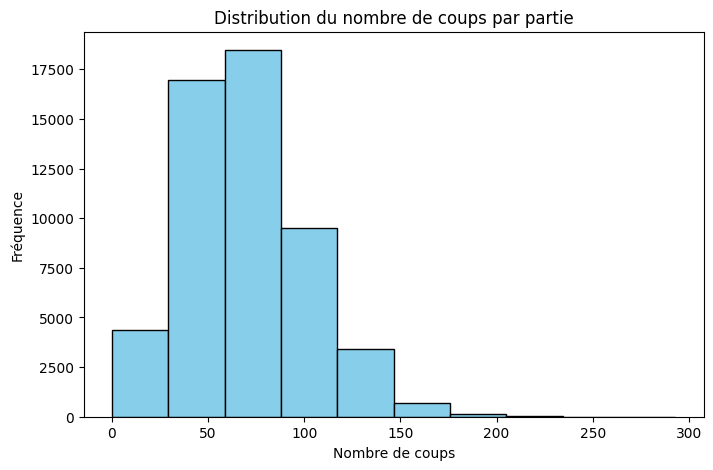

Result                                        Opening  White Win Rate (%)
0                                Van't Kruijs Opening               48.36
1       Scandinavian Defense: Mieses-Kotroc Variation               59.20
2                                     Horwitz Defense               56.72
3                    French Defense: Knight Variation               52.71
4                                      Modern Defense               54.52
5                                    Sicilian Defense               41.46
6                                        Owen Defense               49.93
7                    Sicilian Defense: Bowdler Attack               44.82
8                                 Philidor Defense #3               59.16
9                                   Caro-Kann Defense               49.66
10              Queen's Pawn Game: Chigorin Variation               56.87
11                               Queen's Pawn Game #2               53.31
12                                Phil

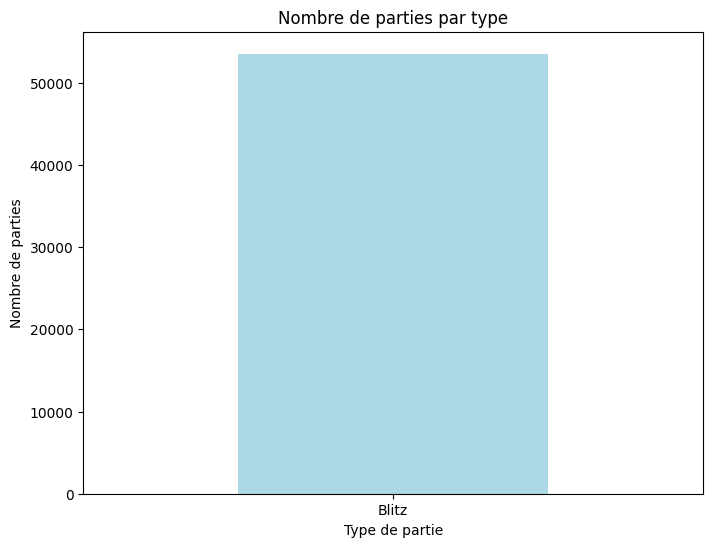

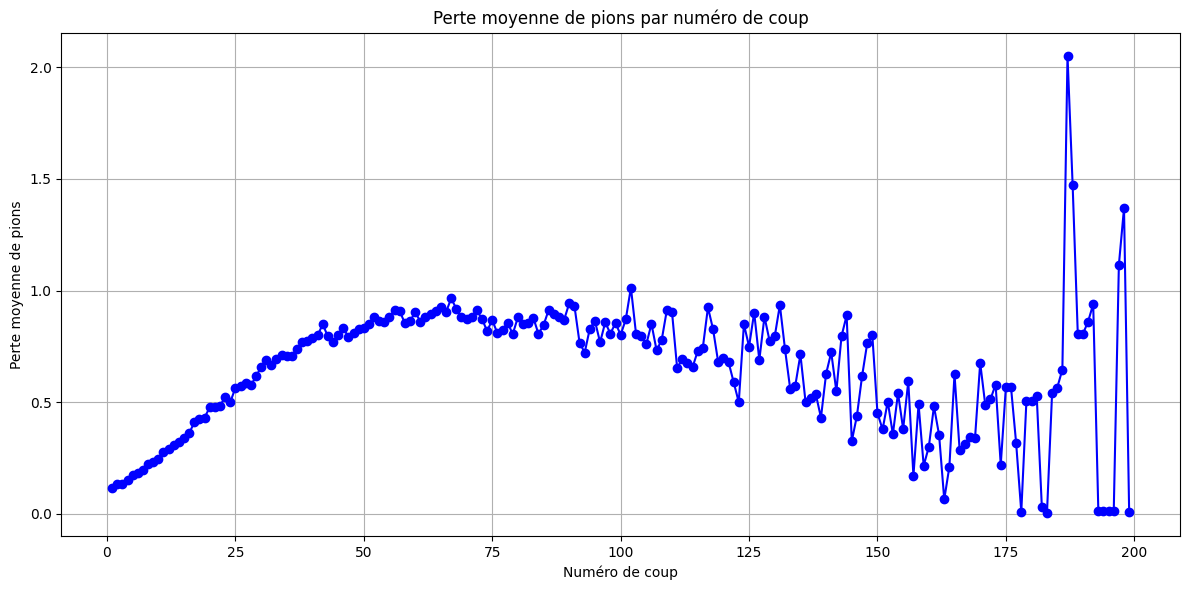

In [53]:
filtered_df_blitz = df_games[df_games["game_type"] == "Blitz"]
statistiques_descriptives(filtered_df_blitz)


Répartition des résultats :
Result
1-0        8779
0-1        8140
1/2-1/2     694
Name: count, dtype: int64


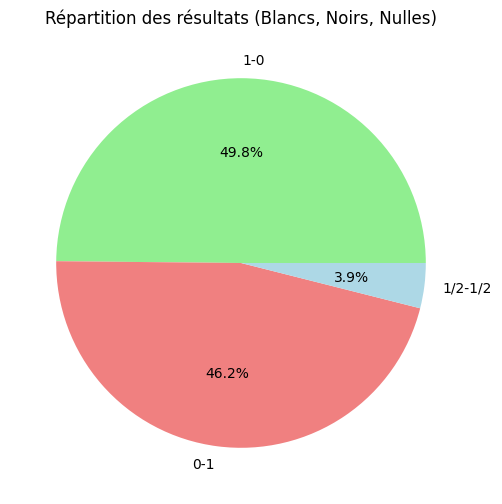


Nombre moyen de coups par partie : 65.22


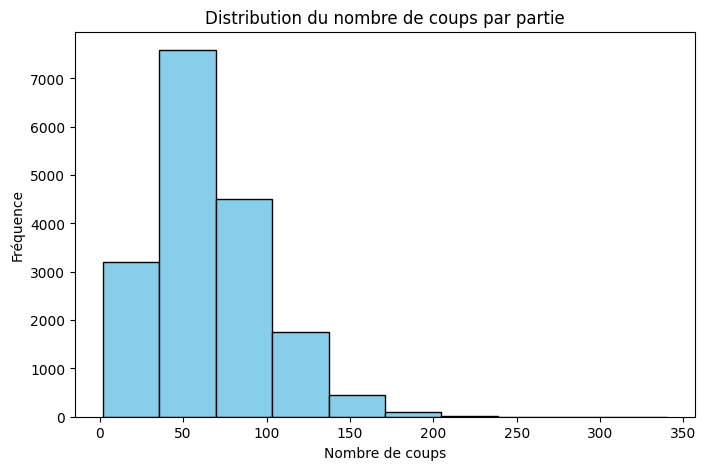

Result                                        Opening  White Win Rate (%)
0                    Sicilian Defense: Bowdler Attack               44.04
1       Scandinavian Defense: Mieses-Kotroc Variation               64.49
2                                Van't Kruijs Opening               48.25
3                                    Bishop's Opening               60.29
4                                 Philidor Defense #2               50.94
5                                     Horwitz Defense               57.03
6                                 Philidor Defense #3               58.78
7                                Scandinavian Defense               42.35
8               Queen's Pawn Game: Chigorin Variation               53.91
9                    French Defense: Knight Variation               49.78
10                                       Owen Defense               50.43
11                                   Sicilian Defense               39.04
12                                    

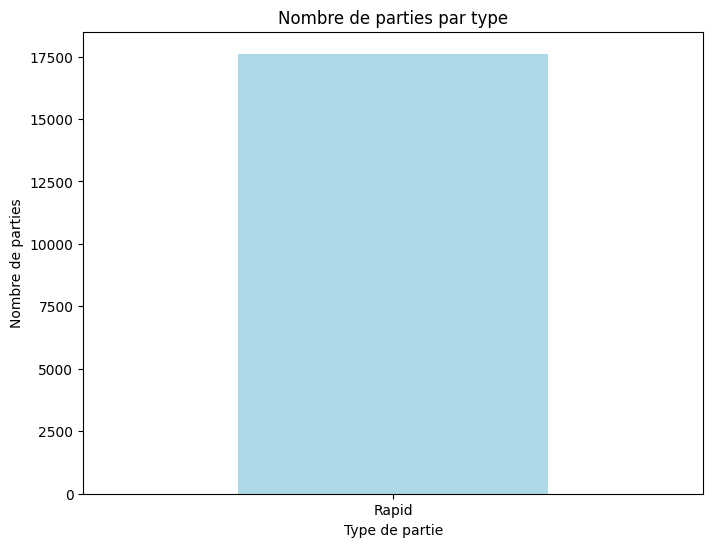

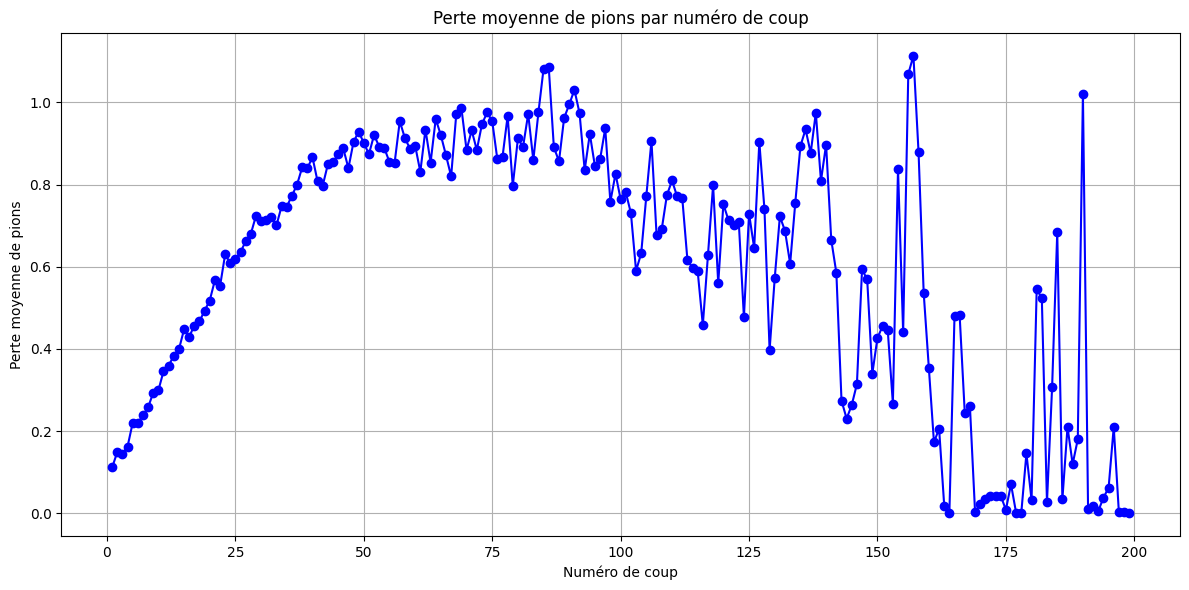

In [54]:
filtered_df_rapid = df_games[df_games["game_type"] == "Rapid"]
statistiques_descriptives(filtered_df_rapid)

On remarque que, sans surprise, les parties bullet sont moins qualitatives que les blitz et les rapid. Il n'y a pas de grande différence entre le blitz et le rapid. On note les ouvertures performantes : Queen's Pawn Game, Mason Attack (60 % de victoires pour les blancs), et la Sicilian Defense (environ 58 % de victoires pour les noirs).


On peut à présent regarder la différence entre les Elo. On peut se restreindre à une tranche d'Elo comprise entre Elo_min et Elo_max.


Répartition des résultats :
Result
1-0        1261
0-1        1166
1/2-1/2     199
Name: count, dtype: int64


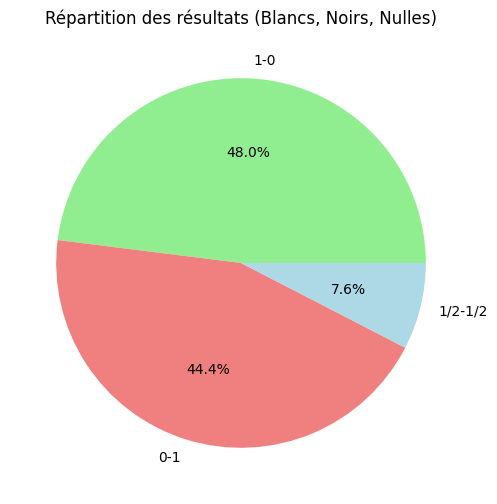


Nombre moyen de coups par partie : 78.04


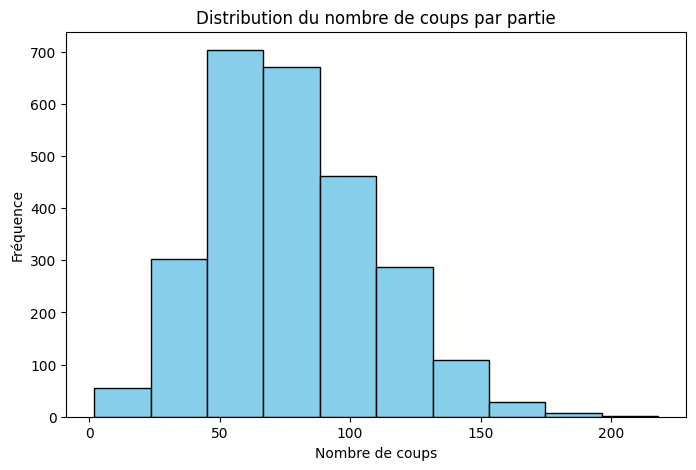

Result                                            Opening  White Win Rate (%)
0                                        Sicilian Defense               50.00
1                     Sicilian Defense: Najdorf Variation               44.00
2                                          Modern Defense               60.00
3                                       Caro-Kann Defense               47.62
4                  Queen's Pawn Game: Zukertort Variation               40.91
5         Sicilian Defense: Modern Variations, Tartakower               47.83
6           Scandinavian Defense: Mieses-Kotroc Variation               54.55
7       Nimzowitsch Defense: Kennedy Variation, Linkss...               68.18
8                                            Queen's Pawn               47.62
9                   Caro-Kann Defense: Exchange Variation               57.89
10                                        Horwitz Defense               40.00
11                                   Van't Kruijs Opening       

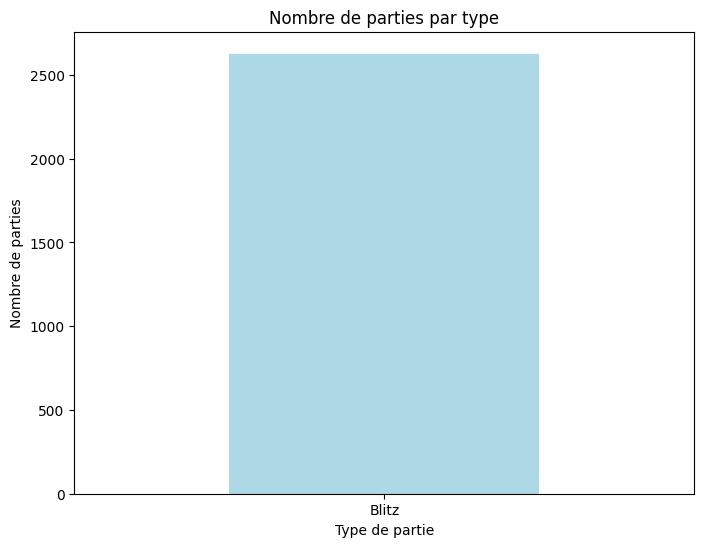

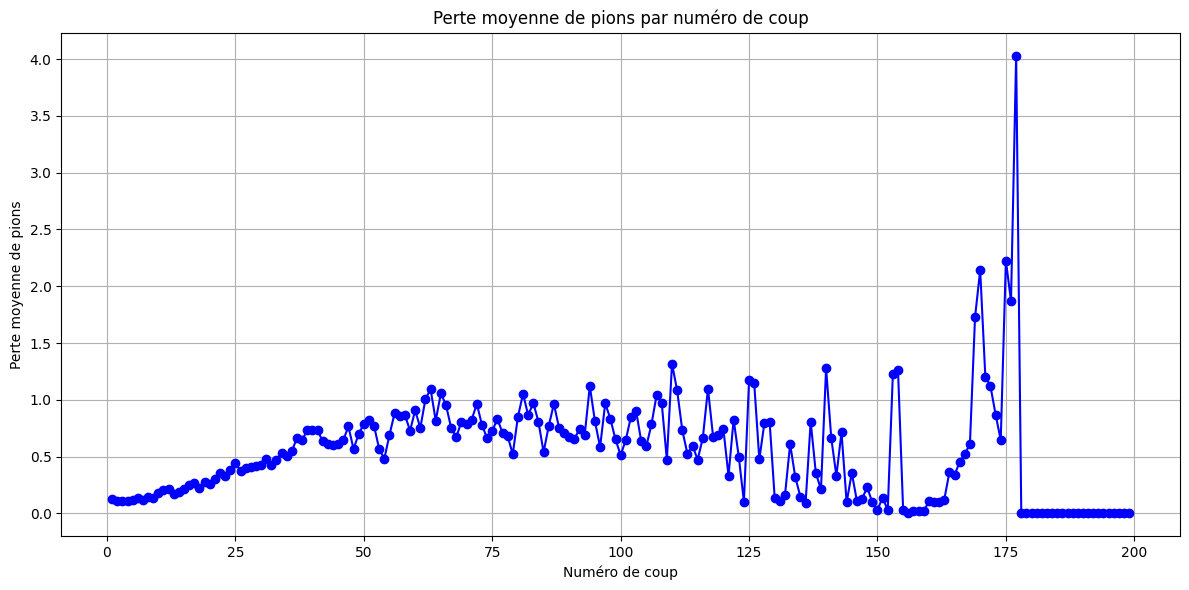

In [55]:
elo_min =1900
elo_max =2200
filtered_df_elo = df_games[(df_games["WhiteElo"] >= elo_min) & (df_games["WhiteElo"] <= elo_max) &(df_games["BlackElo"] >= elo_min) & (df_games["BlackElo"] <= elo_max)]
filtered_df_elo_blitz=filtered_df_elo[filtered_df_elo["game_type"] == "Blitz"]

statistiques_descriptives(filtered_df_elo_blitz)

En filtrant différentes tranches d'Elo, on remarque que les coups gagnent en qualité, le nombre de parties nulles augmente fortement et les parties s'allongent. Les ouvertures à fort winrate changent en fonction de la tranche d'Elo. Par exemple, la défense sicilienne perd en efficacité pour les noirs lorsque l'Elo augmente.

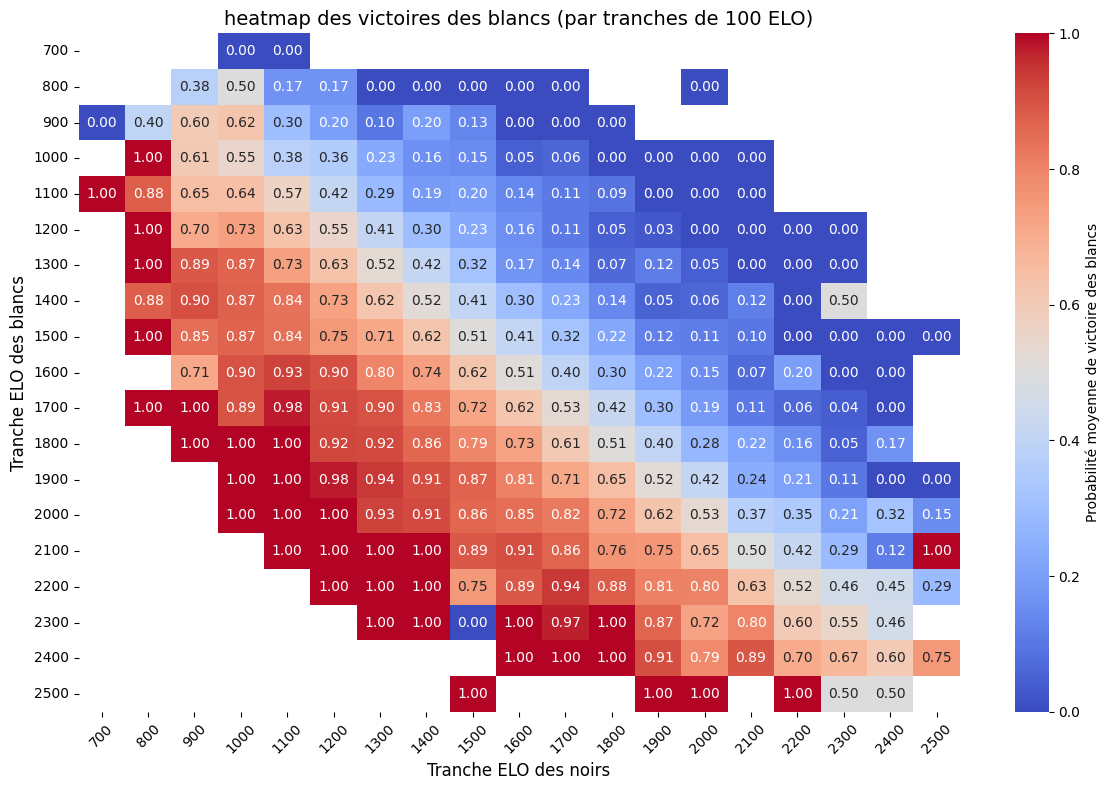

In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap_white_win_prob(df, elo_step=50):


    if not {'WhiteElo', 'BlackElo', 'Result'}.issubset(df.columns):
        raise ValueError("Le dataframe doit contenir les colonnes 'WhiteElo', 'BlackElo', et 'Result'.")

    df['NumericResult'] = df['Result'].map({'1-0': 1, '1/2-1/2': 0.5, '0-1': 0})

    df['WhiteEloRange'] = (df['WhiteElo'] // elo_step) * elo_step
    df['BlackEloRange'] = (df['BlackElo'] // elo_step) * elo_step

    avg_white_win = df.groupby(['WhiteEloRange', 'BlackEloRange'])['NumericResult'].mean().reset_index()

    heatmap_data = avg_white_win.pivot(index='WhiteEloRange', columns='BlackEloRange', values='NumericResult')

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        heatmap_data,
        cmap='coolwarm',
        annot=True,
        fmt=".2f",
        cbar_kws={'label': 'Probabilité moyenne de victoire des blancs'}
    )

    plt.title("heatmap des victoires des blancs (par tranches de 100 ELO)", fontsize=14)
    plt.xlabel("Tranche ELO des noirs", fontsize=12)
    plt.ylabel("Tranche ELO des blancs", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_heatmap_white_win_prob(df_games, elo_step=100)

Loin de la diagonale, on peut trouver des valeurs surprenantes, car il s'agit de matchs rares (le champion du monde d'échecs est rarement apparié contre un débutant). Globalement, on peut lire sur la diagonale que jouer les blancs est d'autant plus un avantage si l'on joue à très bas ou à très haut niveau. Globalement, au-delà de 500 Elo de différence, une victoire est un exploit.

Nombre de parties Blitz analysées: 53541


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-57-750572b51c8c>:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_loss_per_elo = stats_df.groupby("ELO_Range")["MeanCentipawnLoss"].mean()


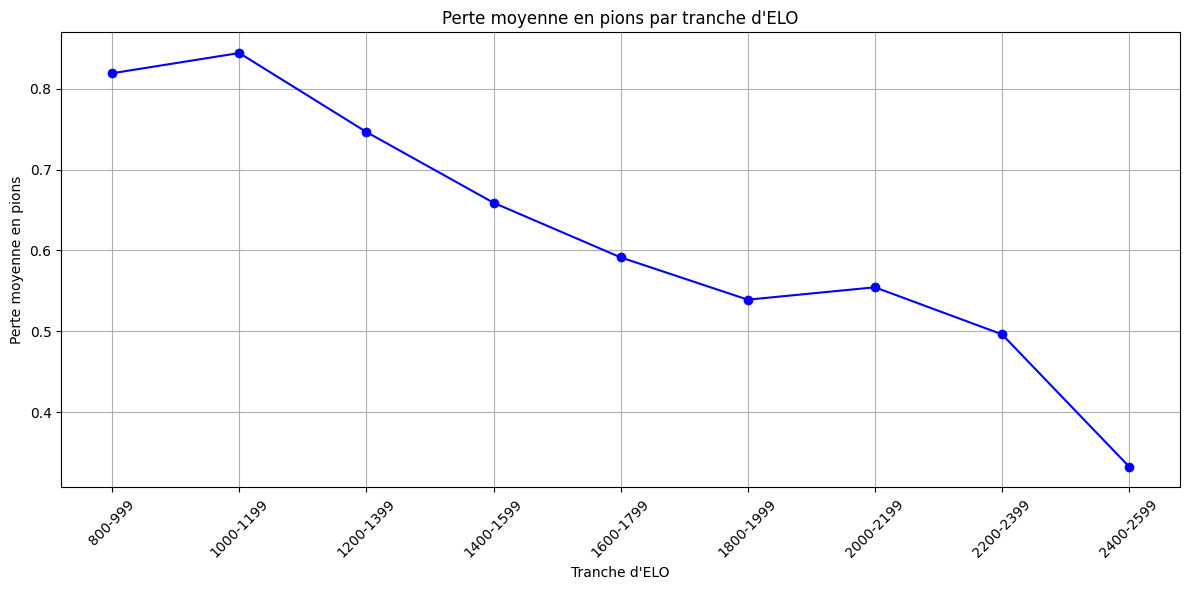

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def filter_analysed_blitz_games(df, elo_range_step=200):


    blitz_df = df[df["game_type"] == "Blitz"]
    blitz_df = blitz_df[blitz_df["centipawn_losses"].apply(lambda x: isinstance(x, list) and len(x) > 0)]
    print(f"Nombre de parties Blitz analysées: {len(blitz_df)}")


    player_stats = []
    for player, group in blitz_df.groupby("White"):
        mean_loss = group["centipawn_losses"].apply(
            lambda losses: np.mean([abs(loss) for loss in losses if loss is not None])
        ).mean()  # Moyenne des pertes sur toutes les parties
        player_elo = group["WhiteElo"].iloc[0]
        player_stats.append({"Player": player, "ELO": player_elo, "MeanCentipawnLoss": mean_loss})


    stats_df = pd.DataFrame(player_stats)

    stats_df["ELO_Range"] = pd.cut(
        stats_df["ELO"],
        bins=np.arange(800, stats_df["ELO"].max() + elo_range_step, elo_range_step),
        labels=[f"{i}-{i+elo_range_step-1}" for i in range(800, stats_df["ELO"].max(), elo_range_step)]
    )

    return stats_df

def plot_elo_vs_centipawn_loss(stats_df):

    mean_loss_per_elo = stats_df.groupby("ELO_Range")["MeanCentipawnLoss"].mean()

    plt.figure(figsize=(12, 6))
    plt.plot(mean_loss_per_elo.index, mean_loss_per_elo.values, marker="o", linestyle="-", color="blue")
    plt.title("Perte moyenne en pions par tranche d'ELO")
    plt.xlabel("Tranche d'ELO")
    plt.ylabel("Perte moyenne en pions")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


filtered_stats_df = filter_analysed_blitz_games(df_games)
plot_elo_vs_centipawn_loss(filtered_stats_df)


La qualité (d'après l'ordinateur) des coups décroît globalement, sauf vers 1000 et 1800 Elo.


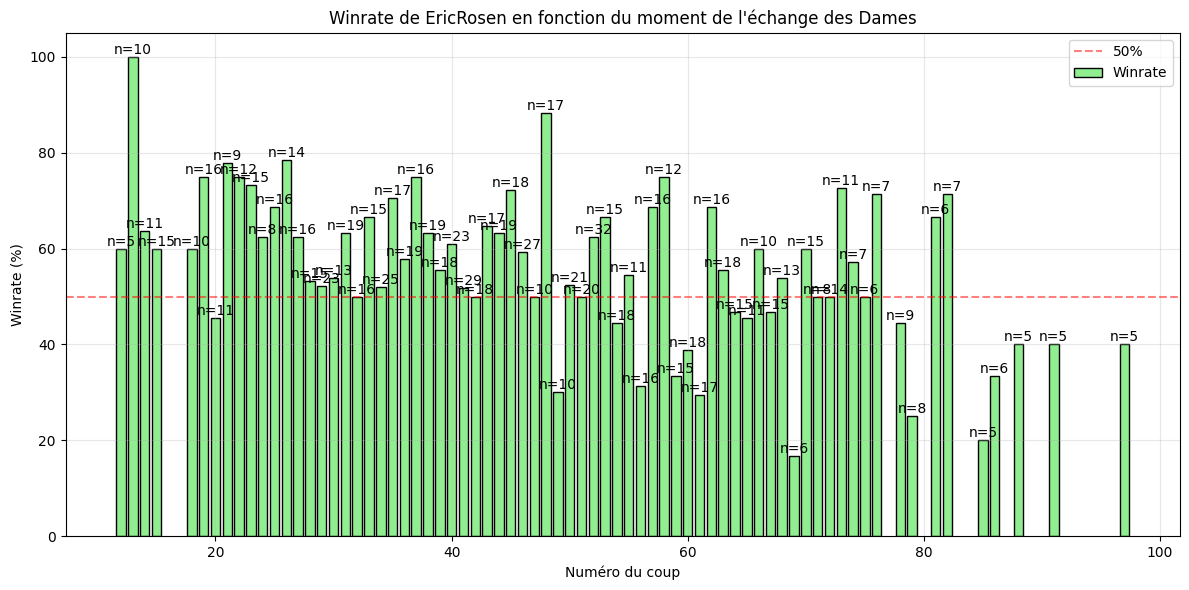

In [58]:
def winrate_queen_exchange(df, username):


    queen_exchange_moves = []
    results_queen_exchange = []

    for _, row in df.iterrows():
        if row["queen_exchange_bool"] and isinstance(row["queen_exchange_move"], int):
            queen_exchange_moves.append(row["queen_exchange_move"])


            if row["White"] == username:
                results_queen_exchange.append(row["Result"] == "1-0")
            else:
                results_queen_exchange.append(row["Result"] == "0-1")


    queen_exchange_data = pd.DataFrame({
        "move": queen_exchange_moves,
        "win": results_queen_exchange
    })

    queen_exchange_winrate = (
        queen_exchange_data.groupby("move")["win"]
        .agg(['mean', 'count'])
        .reset_index()
    )
    queen_exchange_winrate['mean'] = queen_exchange_winrate['mean'] * 100

    queen_exchange_winrate = queen_exchange_winrate[queen_exchange_winrate['count'] >= 5]


    plt.figure(figsize=(12, 6))
    bars = plt.bar(
        queen_exchange_winrate['move'],
        queen_exchange_winrate['mean'],
        color="lightgreen",
        edgecolor="black",
        label="Winrate"
    )
    for bar, count in zip(bars, queen_exchange_winrate['count']):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height,
            f'n={int(count)}',
            ha='center',
            va='bottom'
        )

    plt.title(f"Winrate de {username} en fonction du moment de l'échange des Dames")
    plt.xlabel("Numéro du coup")
    plt.ylabel("Winrate (%)")

    plt.axhline(y=50, color='r', linestyle='--', alpha=0.5, label='50%')

    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



winrate_queen_exchange(df_games_perso, username)

Ce genre d'histogramme permet de mieux cerner le profil d'un joueur (forces/faiblesses)


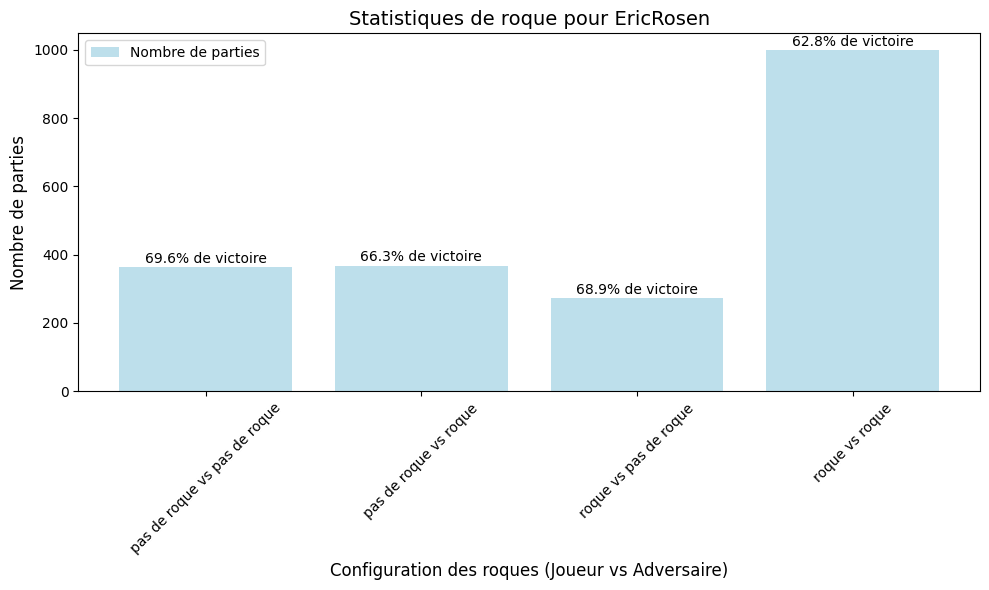

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_castling_stats(df, username):

    results = []
    for _, row in df.iterrows():

        is_white = row['White'] == username


        if row['Result'] == '1-0':
            won = 1 if is_white else 0
        elif row['Result'] == '0-1':
            won = 0 if is_white else 1
        else:  # '1/2-1/2'
            won = 0.5


        if is_white:
            player_castling = ('roque' if row['white_castling_bool'] and row['white_castling_move'] <= 30
                               else 'pas de roque')
            opponent_castling = ('roque' if row['black_castling_bool'] and row['black_castling_move'] <= 30
                                 else 'pas de roque')
        else:
            player_castling = ('roque' if row['black_castling_bool'] and row['black_castling_move'] <= 30
                               else 'pas de roque')
            opponent_castling = ('roque' if row['white_castling_bool'] and row['white_castling_move'] <= 30
                                 else 'pas de roque')

        results.append({
            'player_castling': player_castling,
            'opponent_castling': opponent_castling,
            'won': won
        })


    results_df = pd.DataFrame(results)

    stats = results_df.groupby(['player_castling', 'opponent_castling']).agg({
        'won': ['count', 'mean']
    }).round(3)


    stats.columns = ['games_count', 'win_rate']


    stats = stats.reset_index()

    stats['win_rate'] = (stats['win_rate'] * 100).round(1)

    total_games = len(results_df)
    stats['percentage_of_games'] = (stats['games_count'] / total_games * 100).round(1)

    plt.figure(figsize=(10, 6))
    positions = np.arange(len(stats))
    plt.bar(positions, stats['games_count'],
            color='lightblue', alpha=0.8, label='Nombre de parties')

    for pos, win_rate in zip(positions, stats['win_rate']):
        plt.text(pos, stats['games_count'][pos] + 5, f"{win_rate}% de victoire",
                 ha='center', va='bottom', fontsize=10, color='black')

    plt.title(f'Statistiques de roque pour {username}', fontsize=14)
    plt.xlabel('Configuration des roques (Joueur vs Adversaire)', fontsize=12)
    plt.ylabel('Nombre de parties', fontsize=12)
    plt.xticks(positions, [f"{p_cast} vs {o_cast}"
                          for p_cast, o_cast in zip(stats['player_castling'],
                                                  stats['opponent_castling'])],
               rotation=45, fontsize=10)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()







analyze_castling_stats(df_games_perso, username)

In [60]:
def find_most_common_traps(df, threshold=3, max_moves=12, top_n=10):

    traps_data = []


    for _, row in df.iterrows():
        evaluations = row["evaluations"]
        moves = row["Moves"]
        if evaluations and moves:
            for i in range(min(max_moves, len(evaluations))):
                eval_value = evaluations[i]
                if eval_value is not None and abs(eval_value) >= threshold:

                    sequence = " ".join(moves[:i + 1])
                    traps_data.append(sequence)
                    break
    traps_df = pd.DataFrame(traps_data, columns=["Sequence"])
    most_common_traps = traps_df["Sequence"].value_counts().reset_index()
    most_common_traps.columns = ["Sequence","Occurences"]


    return most_common_traps.head(top_n)



common_traps_2 = find_most_common_traps(df_games, threshold=2, max_moves=10, top_n=10)


print("\nPièges les plus courants (±2 évaluation) :")
print(common_traps_2)

common_traps_3 = find_most_common_traps(df_games, threshold=3, max_moves=10, top_n=10)


print("\nPièges les plus courants (±3 évaluation) :")
print(common_traps_3)


#common_traps.to_csv("most_common_traps.csv", index=False)



Pièges les plus courants (±2 évaluation) :
                                       Sequence  Occurences
0                 e2e4 e7e5 d2d4 b8c6 d4d5 c6d4           6
1  e2e4 e7e5 g1f3 b8c6 f1c4 c6d4 f3e5 d8g5 e5f7           4
2                 e2e4 e7e5 g1f3 f7f6 f3e5 f6e5           3
3                           e2e4 e7e5 d1h5 g7g6           3
4                           e2e4 d7d6 f1c4 b7b6           2
5            e2e4 e7e5 f2f4 e5f4 f1c4 d8h4 g2g3           2
6                 e2e4 e7e5 g1f3 b8c6 d2d4 f8c5           2
7                 e2e4 d7d5 e4d5 d8d5 b1c3 d5c6           2
8       e2e4 e7e5 g1f3 b8c6 f1c4 g8f6 f3g5 d7d6           2
9  e2e4 e7e5 g1f3 b8c6 f1c4 c6d4 f3e5 d8g5 e5f3           2

Pièges les plus courants (±3 évaluation) :
                                       Sequence  Occurences
0  e2e4 e7e5 g1f3 b8c6 f1c4 c6d4 f3e5 d8g5 e5f7           4
1                           e2e4 e7e5 d1h5 g7g6           3
2            e2e4 e7e5 g1f3 b8c6 f1c4 f8c5 f3g5           2
3       e2e4

find_most_common_traps identifie les séquences de coups (dans les premiers coups de la partie) qui offrent un avantage significatif à l'un des deux joueurs. Cette fonction permet d'analyser, pour un joueur en particulier, les pièges qu'il tend à ses adversaires ainsi que les erreurs fréquentes qu'il commet en début de partie.

                               Nombre de parties  Taux de victoire
endgame_type                                                      
Finale après échange de Dames               1073             0.568
Finale avec Dames                            495             0.820
Finale avec une Dame                         313             0.585
Finale sans Dame                             119             0.479


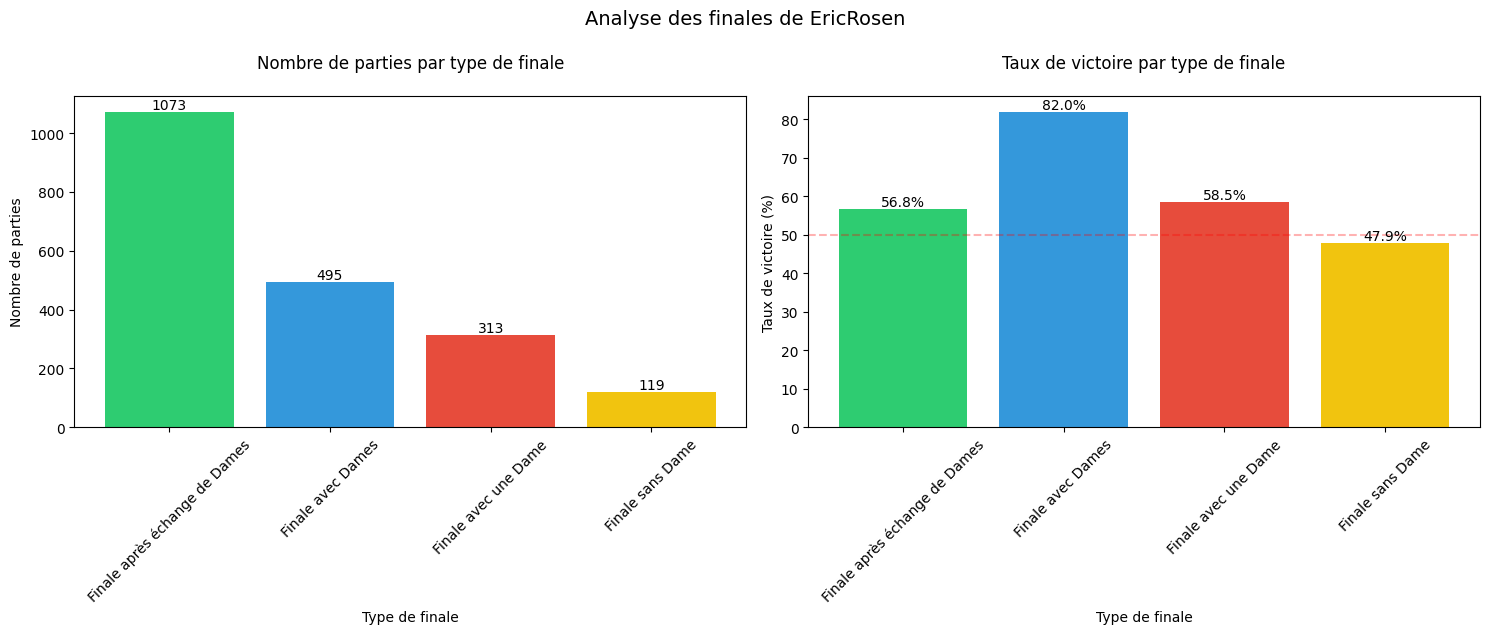

In [68]:
import matplotlib.pyplot as plt

def analyze_endgame_winrate(df, username):
    df['plays_white'] = df['White'].apply(lambda x: 1 if x == username else 0)
    df['won'] = df.apply(lambda x: 1 if
        (x['plays_white'] == 1 and x['Result'] == '1-0') or
        (x['plays_white'] == 0 and x['Result'] == '0-1')
        else 0, axis=1)

    def determine_endgame_type(row):
        white_queen_taken = row['white_queen_taken_bool']
        black_queen_taken = row['black_queen_taken_bool']

        if not white_queen_taken and not black_queen_taken:
            return "Finale avec Dames"
        elif not white_queen_taken or not black_queen_taken:
            return "Finale avec une Dame"
        else:
            if row['queen_exchange_bool']:
                return "Finale après échange de Dames"
            else:
                return "Finale sans Dame"

    df['endgame_type'] = df.apply(determine_endgame_type, axis=1)

    endgame_stats = df.groupby('endgame_type').agg({
        'won': ['count', 'mean']
    }).round(3)

    endgame_stats.columns = ['Nombre de parties', 'Taux de victoire']
    endgame_stats = endgame_stats.sort_values('Nombre de parties', ascending=False)

    return endgame_stats



stats = analyze_endgame_winrate(df_games_perso, username)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


colors = ['#2ecc71', '#3498db', '#e74c3c', '#f1c40f']


ax1.bar(stats.index, stats['Nombre de parties'], color=colors)
ax1.set_title('Nombre de parties par type de finale', pad=20)
ax1.set_xlabel('Type de finale')
ax1.set_ylabel('Nombre de parties')
ax1.tick_params(axis='x', rotation=45)

for i, v in enumerate(stats['Nombre de parties']):
    ax1.text(i, v, str(v), ha='center', va='bottom')


win_rates = stats['Taux de victoire'] * 100
ax2.bar(stats.index, win_rates, color=colors)
ax2.set_title('Taux de victoire par type de finale', pad=20)
ax2.set_xlabel('Type de finale')
ax2.set_ylabel('Taux de victoire (%)')
ax2.tick_params(axis='x', rotation=45)


for i, v in enumerate(win_rates):
    ax2.text(i, v, f'{v:.1f}%', ha='center', va='bottom')


ax2.axhline(y=50, color='red', linestyle='--', alpha=0.3)


plt.tight_layout()


fig.suptitle(f'Analyse des finales de {username}', y=1.05, fontsize=14)


print(stats.to_string())


plt.show()


Erreur quadratique moyenne : 0.14392957786175004
Coefficient de détermination (R²) : -3.347127541686312e-05


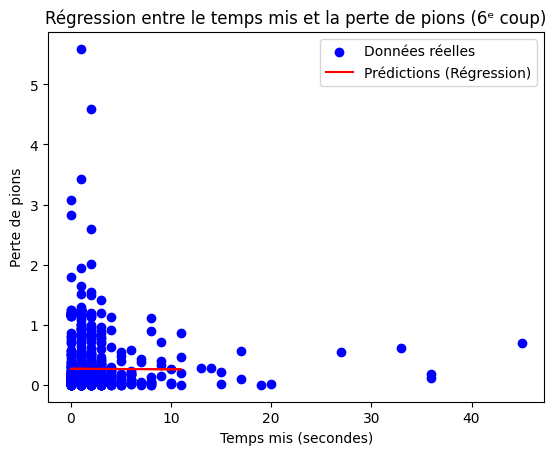

Erreur quadratique moyenne : 0.1966386107072888
Coefficient de détermination (R²) : -0.0841714633759778


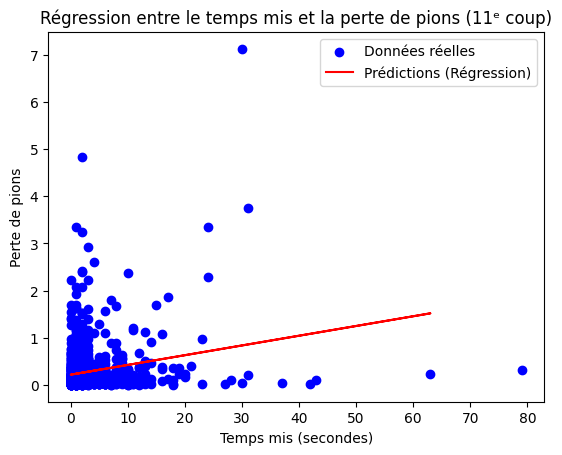

Erreur quadratique moyenne : 0.1481089370603062
Coefficient de détermination (R²) : 0.0006128959302084125


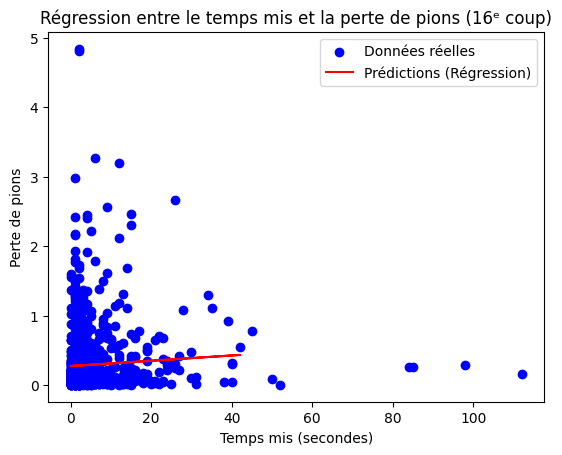

Erreur quadratique moyenne : 0.5007095023460794
Coefficient de détermination (R²) : 0.010684668040615852


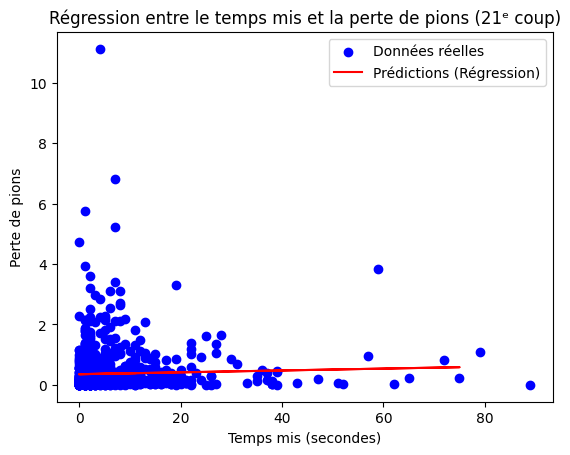

Erreur quadratique moyenne : 0.48123604552312127
Coefficient de détermination (R²) : 0.02390946360238122


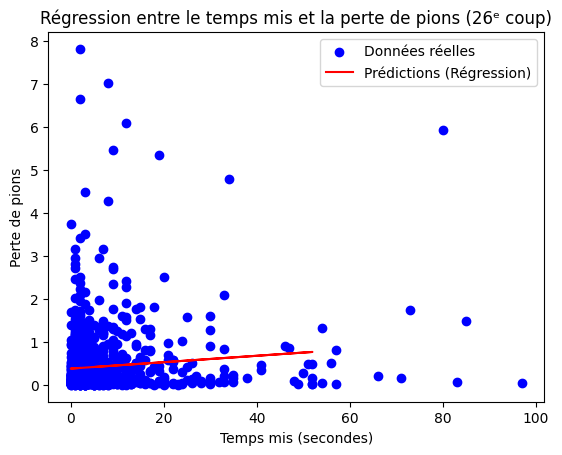

Erreur quadratique moyenne : 0.9804445286137028
Coefficient de détermination (R²) : -0.006150526377343368


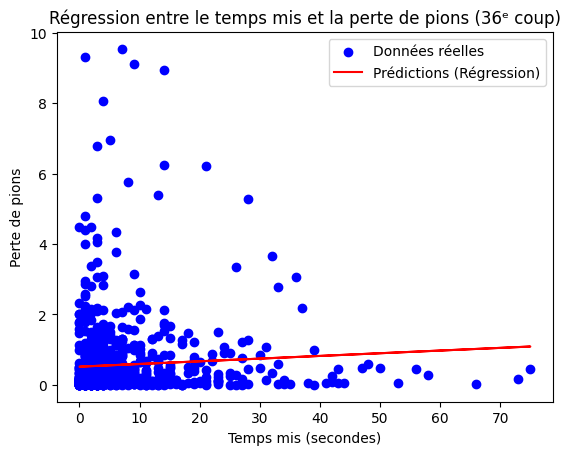

Erreur quadratique moyenne : 0.6774663557947573
Coefficient de détermination (R²) : -0.00803012345318499


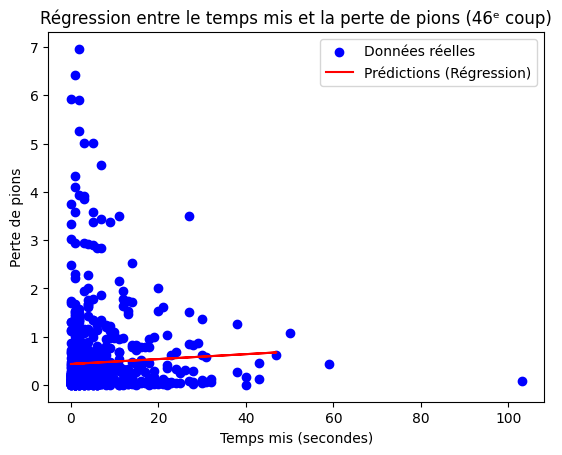

Erreur quadratique moyenne : 1.925665321455785
Coefficient de détermination (R²) : -0.02466345900825795


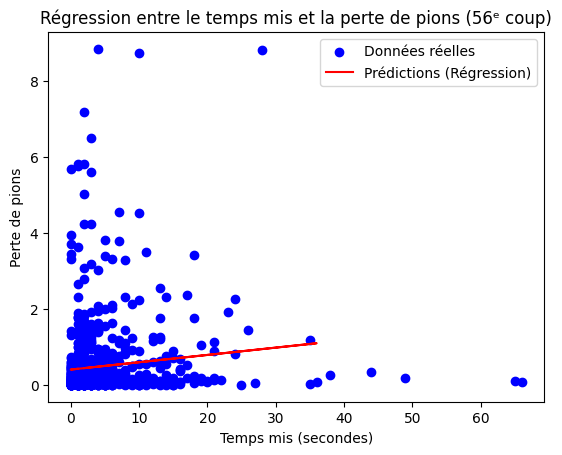

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def preprocess_time_by_color(df, i, max_time_per_move=180):

    processed_data = []

    for _, row in df.iterrows():
        clocks = row["clocks"]
        evaluations = row["evaluations"]

        if (
            isinstance(clocks, list)
            and isinstance(evaluations, list)
            and len(clocks) > i
            and len(evaluations) > i
        ):
            try:
                if i % 2 == 0:    #Coup des blancs
                    current_time = clocks[i]
                    previous_time = clocks[i -2] if i- 2>=0 else None
                else:  #Coup des noirs
                    current_time = clocks[i]
                    previous_time = clocks[i -2] if i-2>=0 else None


                current_time_sec = sum(float(x) * 60 ** idx for idx, x in enumerate(reversed(current_time.split(":")))) # Conversion des horloges en secondes
                previous_time_sec = sum(float(x) * 60 ** idx for idx, x in enumerate(reversed(previous_time.split(":")))) if previous_time else None

                time_used = previous_time_sec - current_time_sec if previous_time_sec else None

                diff_eval=abs(evaluations[i]-evaluations[i-1])
                # Filtrer les valeurs absurdes
                if time_used is not None and 0 <= time_used <= max_time_per_move:
                    processed_data.append({
                        "time_used": time_used,
                        "centipawn_loss": diff_eval
                    })

            except Exception as e:

                continue

    return pd.DataFrame(processed_data)

def perform_regression_on_ith_move(df, i):


    processed_df = preprocess_time_by_color(df, i)

    if processed_df.empty:
        print("Pas de données valides pour le coup", i)
        return


    processed_df = processed_df.dropna(subset=["time_used", "centipawn_loss"])  #gestion valeur manquante

    if processed_df.empty:
        print("Pas de données après suppression des NaN pour le coup", i)
        return


    X = processed_df[["time_used"]].values

    y = processed_df["centipawn_loss"].values


    if len(X) < 2:
        print("Pas assez de données pour effectuer une régression pour le coup", i)
        return
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)      # Séparation en ensembles d'entraînement et de test


    model = LinearRegression()  #modèle de régression
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)


    print("Erreur quadratique moyenne :", mean_squared_error(y_test, y_pred))
    print("Coefficient de détermination (R²) :", r2_score(y_test, y_pred))


    plt.scatter(X, y, color="blue", label="Données réelles")
    plt.plot(X_test, y_pred, color="red", label="Prédictions (Régression)")
    plt.xlabel("Temps mis (secondes)")
    plt.ylabel("Perte de pions")
    plt.title(f"Régression entre le temps mis et la perte de pions ({i+1}ᵉ coup)")
    plt.legend()
    plt.show()





filtered_perso_blitz = df_games_perso[df_games_perso["game_type"] == "Blitz"]

perform_regression_on_ith_move(filtered_perso_blitz, i=5)


perform_regression_on_ith_move(filtered_perso_blitz, i=10)

perform_regression_on_ith_move(filtered_perso_blitz, i=15)

perform_regression_on_ith_move(filtered_perso_blitz, i=20)

perform_regression_on_ith_move(filtered_perso_blitz, i=25)

perform_regression_on_ith_move(filtered_perso_blitz, i=35)

perform_regression_on_ith_move(filtered_perso_blitz, i=45)
perform_regression_on_ith_move(filtered_perso_blitz, i=55)
perform_regression_on_ith_move(filtered_perso_blitz, i=65)


Le temps pris pour jouer un coup n'a pas de lien évident avec la perte en pions (reflétant à quel point le coup est mauvais), quelle que soit la phase de la partie. En effet,le R2 obtenu est proche de 0, voire négatif dans certains cas. Cela indique que le modèle explique moins bien la variation des données qu'une prédiction constante basée sur la moyenne.

On peut en revanche observer la correlation.


In [62]:
import pandas as pd
from scipy.stats import pearsonr

def calculate_correlation_on_ith_move(df, i, max_time_per_move=180):

    processed_df = preprocess_time_by_color(df, i, max_time_per_move)

    if processed_df.empty:
        print(f"pas de donnee pour le coup {i}")
        return None

    processed_df = processed_df.dropna(subset=["time_used", "centipawn_loss"])

    if processed_df.empty:
        print(f" pas de donnee pour le coup{i}")
        return None


    time_used = processed_df["time_used"].values
    centipawn_loss = processed_df["centipawn_loss"].values


    correlation, p_value = pearsonr(time_used, centipawn_loss)

    print(f"Corrélation entre le temps utilisé et la perte de pions (Coup {i}): {correlation:.3f}")
    print(f"p-value : {p_value:.3f}")

    return correlation


filtered_perso_blitz = df_games_perso[df_games_perso["game_type"] == "Blitz"]

calculate_correlation_on_ith_move(filtered_perso_blitz, i=5)
calculate_correlation_on_ith_move(filtered_perso_blitz, i=10)
calculate_correlation_on_ith_move(filtered_perso_blitz, i=15)
calculate_correlation_on_ith_move(filtered_perso_blitz, i=25)
calculate_correlation_on_ith_move(filtered_perso_blitz, i=35)
calculate_correlation_on_ith_move(filtered_perso_blitz, i=45)
calculate_correlation_on_ith_move(filtered_perso_blitz, i=55)
calculate_correlation_on_ith_move(filtered_perso_blitz, i=65)




Corrélation entre le temps utilisé et la perte de pions (Coup 5): -0.006
p-value : 0.860
Corrélation entre le temps utilisé et la perte de pions (Coup 10): 0.175
p-value : 0.000
Corrélation entre le temps utilisé et la perte de pions (Coup 15): 0.082
p-value : 0.010
Corrélation entre le temps utilisé et la perte de pions (Coup 25): 0.115
p-value : 0.000
Corrélation entre le temps utilisé et la perte de pions (Coup 35): 0.055
p-value : 0.095
Corrélation entre le temps utilisé et la perte de pions (Coup 45): 0.029
p-value : 0.396
Corrélation entre le temps utilisé et la perte de pions (Coup 55): 0.087
p-value : 0.018
Corrélation entre le temps utilisé et la perte de pions (Coup 65): 0.046
p-value : 0.239


0.046247441781625015

In [83]:
import pandas as pd
import statsmodels.api as sm

def significant_predictors_with_endgames(username, max_games=2000):


    data = df_games_perso.head(max_games)
    data['Plays_white'] = data['White'].apply(lambda x: 1 if x == username else 0)
    data['Won'] = data.apply(lambda x: 1 if
                             (x['Plays_white'] == 1 and x['Result'] == '1-0') or
                             (x['Plays_white'] == 0 and x['Result'] == '0-1')
                             else 0, axis=1)


    add_variables_perso(data)


    def determine_endgame_type(row):
        white_queen_taken = row['white_queen_taken_bool']
        black_queen_taken = row['black_queen_taken_bool']

        if not white_queen_taken and not black_queen_taken:
            return "Finale avec Dames"
        elif not white_queen_taken or not black_queen_taken:
            return "Finale avec une Dame"
        else:
            if row['queen_exchange_bool']:
                return "Finale après échange de Dames"
            else:
                return None


    data['endgame_type'] = data.apply(determine_endgame_type, axis=1)

    endgame_dummies = pd.get_dummies(data['endgame_type'], prefix='endgame')
    data = pd.concat([data, endgame_dummies], axis=1)


    for col in endgame_dummies.columns:
        data[col] = data[col].astype(int)


    data['Intercept'] = 1


    variables = ['Intercept', "length_game_medium", "length_game_long"
                 , "Enemy_castling_dummy", "Player_castling_dummy"] + list(endgame_dummies.columns)

    data = data[['Won'] + variables].dropna()
    y = data['Won']  # Variable dépendante
    X = data[variables]  # Variables indépendantes



    model = sm.Logit(y, X)
    result = model.fit()


    positive_predictors = []
    negative_predictors = []

    for var, coef, pval in zip(variables[1:], result.params[1:], result.pvalues[1:]):
        if pval < 0.1:  # Seuil de significativité
            if coef > 0:
                positive_predictors.append(var)
            elif coef < 0:
                negative_predictors.append(var)


    print(result.summary())

    return positive_predictors, negative_predictors


positive, negative = significant_predictors_with_endgames(username)
print("\nPrédicteurs positifs :", positive)
print("Prédicteurs négatifs :", negative)


Optimization terminated successfully.
         Current function value: 0.596043
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    Won   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1992
Method:                           MLE   Df Model:                            7
Date:                Sun, 29 Dec 2024   Pseudo R-squ.:                 0.09728
Time:                        20:57:46   Log-Likelihood:                -1192.1
converged:                       True   LL-Null:                       -1320.5
Covariance Type:            nonrobust   LLR p-value:                 9.321e-52
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 2.1580      